## 전처리한 데이터 가지고 오기

In [1]:
%pip install -q lightgbm scikit-learn optuna

Note: you may need to restart the kernel to use updated packages.


In [6]:
# ライブラリのインポート
import pandas as pd
import lightgbm as lgb
import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from lightgbm import early_stopping, log_evaluation

In [7]:
# データ読み込み
df = pd.read_csv('../data/combined_batches_cleaned_26k_3.csv')

In [8]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78000 entries, 0 to 77999
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   url                   78000 non-null  object 
 1   url_type              78000 non-null  int64  
 2   url_len               78000 non-null  int64  
 3   letters_count         78000 non-null  int64  
 4   digits_count          78000 non-null  int64  
 5   special_chars_count   78000 non-null  int64  
 6   shortened             78000 non-null  int64  
 7   is_domain_in_url      78000 non-null  int64  
 8   secure_http           78000 non-null  int64  
 9   redirect_count        78000 non-null  int64  
 10  duration_sec          78000 non-null  float64
 11  meta_count            78000 non-null  float64
 12  link_count            78000 non-null  float64
 13  title_count           78000 non-null  float64
 14  has_title             78000 non-null  bool   
 15  has_meta_descriptio

,url,url_type,url_len,letters_count,digits_count,special_chars_count,shortened,is_domain_in_url,secure_http,redirect_count,...,has_og_image,has_og_title,has_link_stylesheet,performance_score,FCP,LCP,CLS,TTFB,SpeedIndex,TBT
0,123people.com/c/george+beers,0,28,21,3,4,0,0,0,1,...,False,True,True,0.98,522.000000,642.000000,0.033901,944.0,1374.654466,0.0
1,biographi.ca/009004-119.01-e.php?&id_nbr=8097,0,45,20,15,10,0,0,0,4,...,True,True,True,0.94,822.038853,1046.341351,0.034177,199.0,1866.525789,25.5
2,http://xhamster.com/movies/1515821/bisexual_cu...,0,94,77,7,17,0,1,0,2,...,True,True,True,0.50,1512.414532,5089.235989,0.012295,700.0,2208.209373,399.0
3,nannu.info/music/artists/shreya-ghoshal/,0,40,34,0,6,0,0,0,1,...,False,False,False,0.78,906.283111,1703.476934,0.071229,116.0,2767.985784,214.0
4,en.wikipedia.org/wiki/Walloons,0,30,26,0,4,0,0,0,1,...,True,True,True,0.96,504.000000,1032.000000,0.000892,355.0,1758.528203,11.5


特徴量とラベルに分割

In [9]:
# 特徴量とラベルの分離
y = df['url_type']  # ← 例：0=benign, 1=phishing, 2=malwareなど
X = df.drop(columns=['url_type', 'url_len', 'letters_count'])
X = X.select_dtypes(include=['int64', 'float64', 'bool'])

学習・検証データに分割

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

LightGBMデータ形式に変換

In [11]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

### Optunaによるハイパーパラメータチューニング

In [16]:
def objective(trial):
    param = {
        'objective': 'multiclass',
        'num_class': y.nunique(),
        'metric': 'multi_logloss',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'verbosity': -1,
        'feature_pre_filter': False
    }

    # ここで Dataset を都度作成することで pre_filter 問題を回避
    train_dataset = lgb.Dataset(X_train, label=y_train)
    valid_dataset = lgb.Dataset(X_test, label=y_test)

    model = lgb.train(
        param,
        train_dataset,
        valid_sets=[valid_dataset],
        num_boost_round=100,
        callbacks=[
            early_stopping(stopping_rounds=10),
            log_evaluation(period=0)
        ]
    )

    preds = model.predict(X_test)
    pred_labels = preds.argmax(axis=1)
    accuracy = (pred_labels == y_test).mean()
    return accuracy


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("🔧 Best parameters found by Optuna:")
print(study.best_params)

[I 2025-06-09 10:48:18,786] A new study created in memory with name: no-name-2f6a56ec-120b-43e3-b565-692fed9d1b86


Training until validation scores don't improve for 10 rounds


[I 2025-06-09 10:48:19,519] Trial 0 finished with value: 0.8618589743589744 and parameters: {'learning_rate': 0.22989130861241608, 'num_leaves': 100, 'max_depth': 5, 'min_data_in_leaf': 58, 'feature_fraction': 0.6829292152702559, 'bagging_fraction': 0.6179793090321158, 'bagging_freq': 5}. Best is trial 0 with value: 0.8618589743589744.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.326843
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 10:48:21,059] Trial 1 finished with value: 0.8628846153846154 and parameters: {'learning_rate': 0.039870921134595755, 'num_leaves': 83, 'max_depth': 12, 'min_data_in_leaf': 36, 'feature_fraction': 0.9850801820783551, 'bagging_fraction': 0.6600883632363351, 'bagging_freq': 4}. Best is trial 1 with value: 0.8628846153846154.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.333004
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 10:48:22,252] Trial 2 finished with value: 0.8694871794871795 and parameters: {'learning_rate': 0.11711213341787839, 'num_leaves': 57, 'max_depth': 9, 'min_data_in_leaf': 100, 'feature_fraction': 0.8512238020264447, 'bagging_fraction': 0.7429294966510767, 'bagging_freq': 2}. Best is trial 2 with value: 0.8694871794871795.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.303032
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 10:48:23,809] Trial 3 finished with value: 0.8812820512820513 and parameters: {'learning_rate': 0.2530907321184227, 'num_leaves': 114, 'max_depth': 13, 'min_data_in_leaf': 61, 'feature_fraction': 0.762952022068451, 'bagging_fraction': 0.7449443994787757, 'bagging_freq': 5}. Best is trial 3 with value: 0.8812820512820513.


Early stopping, best iteration is:
[76]	valid_0's multi_logloss: 0.27657
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 10:48:25,150] Trial 4 finished with value: 0.8582692307692308 and parameters: {'learning_rate': 0.07095340022989267, 'num_leaves': 50, 'max_depth': 7, 'min_data_in_leaf': 16, 'feature_fraction': 0.7213717496760103, 'bagging_fraction': 0.9497385118957928, 'bagging_freq': 3}. Best is trial 3 with value: 0.8812820512820513.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.33612
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 10:48:27,036] Trial 5 finished with value: 0.8817948717948718 and parameters: {'learning_rate': 0.1411873704449431, 'num_leaves': 119, 'max_depth': 10, 'min_data_in_leaf': 27, 'feature_fraction': 0.9417815845430605, 'bagging_fraction': 0.8457179582315819, 'bagging_freq': 6}. Best is trial 5 with value: 0.8817948717948718.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.275652
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 10:48:27,834] Trial 6 finished with value: 0.8291666666666667 and parameters: {'learning_rate': 0.1766275481635632, 'num_leaves': 113, 'max_depth': 3, 'min_data_in_leaf': 65, 'feature_fraction': 0.931193207025335, 'bagging_fraction': 0.8590679570176794, 'bagging_freq': 2}. Best is trial 5 with value: 0.8817948717948718.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.395297
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 10:48:28,881] Trial 7 finished with value: 0.8466025641025641 and parameters: {'learning_rate': 0.08970150045532711, 'num_leaves': 107, 'max_depth': 5, 'min_data_in_leaf': 24, 'feature_fraction': 0.806340099233382, 'bagging_fraction': 0.7004203107062938, 'bagging_freq': 5}. Best is trial 5 with value: 0.8817948717948718.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.365111
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 10:48:30,748] Trial 8 finished with value: 0.8844871794871795 and parameters: {'learning_rate': 0.16375616669233814, 'num_leaves': 128, 'max_depth': 12, 'min_data_in_leaf': 22, 'feature_fraction': 0.8163855017213247, 'bagging_fraction': 0.892491857852717, 'bagging_freq': 7}. Best is trial 8 with value: 0.8844871794871795.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.269208
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 10:48:31,514] Trial 9 finished with value: 0.7892307692307692 and parameters: {'learning_rate': 0.03620082596357113, 'num_leaves': 58, 'max_depth': 3, 'min_data_in_leaf': 39, 'feature_fraction': 0.6384439672031975, 'bagging_fraction': 0.962700202548263, 'bagging_freq': 1}. Best is trial 8 with value: 0.8844871794871795.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.502817
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 10:48:33,045] Trial 10 finished with value: 0.8840384615384616 and parameters: {'learning_rate': 0.2926279024389892, 'num_leaves': 150, 'max_depth': 15, 'min_data_in_leaf': 10, 'feature_fraction': 0.8590098164924254, 'bagging_fraction': 0.8778391955721198, 'bagging_freq': 7}. Best is trial 8 with value: 0.8844871794871795.


Early stopping, best iteration is:
[58]	valid_0's multi_logloss: 0.275136
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 10:48:35,372] Trial 11 finished with value: 0.8857692307692308 and parameters: {'learning_rate': 0.1901196435761378, 'num_leaves': 146, 'max_depth': 15, 'min_data_in_leaf': 12, 'feature_fraction': 0.8615237181545737, 'bagging_fraction': 0.8922445474591404, 'bagging_freq': 7}. Best is trial 11 with value: 0.8857692307692308.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.271312
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 10:48:37,574] Trial 12 finished with value: 0.8872435897435897 and parameters: {'learning_rate': 0.18955968333161172, 'num_leaves': 150, 'max_depth': 15, 'min_data_in_leaf': 41, 'feature_fraction': 0.8636132740137323, 'bagging_fraction': 0.9140963895264709, 'bagging_freq': 7}. Best is trial 12 with value: 0.8872435897435897.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.266764
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 10:48:39,567] Trial 13 finished with value: 0.8842307692307693 and parameters: {'learning_rate': 0.2143927553150687, 'num_leaves': 150, 'max_depth': 15, 'min_data_in_leaf': 76, 'feature_fraction': 0.9019449184316132, 'bagging_fraction': 0.8035363343846764, 'bagging_freq': 7}. Best is trial 12 with value: 0.8872435897435897.


Early stopping, best iteration is:
[80]	valid_0's multi_logloss: 0.273181
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 10:48:40,638] Trial 14 finished with value: 0.8645512820512821 and parameters: {'learning_rate': 0.18721117810025747, 'num_leaves': 22, 'max_depth': 14, 'min_data_in_leaf': 45, 'feature_fraction': 0.8853268653797988, 'bagging_fraction': 0.9909601974800213, 'bagging_freq': 6}. Best is trial 12 with value: 0.8872435897435897.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.314985
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 10:48:42,712] Trial 15 finished with value: 0.8833974358974359 and parameters: {'learning_rate': 0.25836778312734404, 'num_leaves': 136, 'max_depth': 10, 'min_data_in_leaf': 79, 'feature_fraction': 0.7547394781512375, 'bagging_fraction': 0.9247175359714702, 'bagging_freq': 6}. Best is trial 12 with value: 0.8872435897435897.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.273221
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 10:48:44,508] Trial 16 finished with value: 0.8859615384615385 and parameters: {'learning_rate': 0.20138752673055674, 'num_leaves': 87, 'max_depth': 13, 'min_data_in_leaf': 47, 'feature_fraction': 0.9957630306379167, 'bagging_fraction': 0.820380433554179, 'bagging_freq': 7}. Best is trial 12 with value: 0.8872435897435897.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.270345
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 10:48:46,285] Trial 17 finished with value: 0.879423076923077 and parameters: {'learning_rate': 0.13780846781099843, 'num_leaves': 88, 'max_depth': 12, 'min_data_in_leaf': 47, 'feature_fraction': 0.992539466639061, 'bagging_fraction': 0.8052917681662137, 'bagging_freq': 4}. Best is trial 12 with value: 0.8872435897435897.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.279386
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 10:48:48,044] Trial 18 finished with value: 0.8828846153846154 and parameters: {'learning_rate': 0.2129710261230591, 'num_leaves': 76, 'max_depth': 13, 'min_data_in_leaf': 51, 'feature_fraction': 0.9557095075863911, 'bagging_fraction': 0.76003252590698, 'bagging_freq': 6}. Best is trial 12 with value: 0.8872435897435897.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.276129
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 10:48:48,907] Trial 19 finished with value: 0.8693589743589744 and parameters: {'learning_rate': 0.2848242760757844, 'num_leaves': 21, 'max_depth': 11, 'min_data_in_leaf': 36, 'feature_fraction': 0.9132610483432138, 'bagging_fraction': 0.8351613754197781, 'bagging_freq': 5}. Best is trial 12 with value: 0.8872435897435897.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.30299
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 10:48:50,429] Trial 20 finished with value: 0.8778846153846154 and parameters: {'learning_rate': 0.24504845657242144, 'num_leaves': 43, 'max_depth': 14, 'min_data_in_leaf': 74, 'feature_fraction': 0.6156037528400972, 'bagging_fraction': 0.928255532718956, 'bagging_freq': 7}. Best is trial 12 with value: 0.8872435897435897.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.282827
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 10:48:52,797] Trial 21 finished with value: 0.8838461538461538 and parameters: {'learning_rate': 0.2003333262714386, 'num_leaves': 140, 'max_depth': 15, 'min_data_in_leaf': 34, 'feature_fraction': 0.8484049234022841, 'bagging_fraction': 0.8984245646184864, 'bagging_freq': 7}. Best is trial 12 with value: 0.8872435897435897.


Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.269881
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 10:48:54,761] Trial 22 finished with value: 0.8832692307692308 and parameters: {'learning_rate': 0.1731625210907344, 'num_leaves': 128, 'max_depth': 14, 'min_data_in_leaf': 29, 'feature_fraction': 0.8821480446044184, 'bagging_fraction': 0.8278040052770227, 'bagging_freq': 6}. Best is trial 12 with value: 0.8872435897435897.


Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.270834
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 10:48:56,779] Trial 23 finished with value: 0.8818589743589743 and parameters: {'learning_rate': 0.11047114221341246, 'num_leaves': 97, 'max_depth': 13, 'min_data_in_leaf': 14, 'feature_fraction': 0.764265134192015, 'bagging_fraction': 0.9059998066453682, 'bagging_freq': 7}. Best is trial 12 with value: 0.8872435897435897.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.278374
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 10:48:59,522] Trial 24 finished with value: 0.8869871794871795 and parameters: {'learning_rate': 0.20065297674656352, 'num_leaves': 139, 'max_depth': 15, 'min_data_in_leaf': 68, 'feature_fraction': 0.9582243967279218, 'bagging_fraction': 0.9960747106711242, 'bagging_freq': 6}. Best is trial 12 with value: 0.8872435897435897.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.267872
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 10:49:01,495] Trial 25 finished with value: 0.8773717948717948 and parameters: {'learning_rate': 0.1517733657847602, 'num_leaves': 129, 'max_depth': 8, 'min_data_in_leaf': 68, 'feature_fraction': 0.9603416989474204, 'bagging_fraction': 0.9996143687825653, 'bagging_freq': 6}. Best is trial 12 with value: 0.8872435897435897.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.289313
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 10:49:03,436] Trial 26 finished with value: 0.8859615384615385 and parameters: {'learning_rate': 0.2221224383715284, 'num_leaves': 76, 'max_depth': 14, 'min_data_in_leaf': 91, 'feature_fraction': 0.9817633540168175, 'bagging_fraction': 0.9551154308955588, 'bagging_freq': 6}. Best is trial 12 with value: 0.8872435897435897.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.271642
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 10:49:05,722] Trial 27 finished with value: 0.8856410256410256 and parameters: {'learning_rate': 0.2696394325278771, 'num_leaves': 136, 'max_depth': 11, 'min_data_in_leaf': 45, 'feature_fraction': 0.9190910627068921, 'bagging_fraction': 0.9750294115027098, 'bagging_freq': 5}. Best is trial 12 with value: 0.8872435897435897.


Early stopping, best iteration is:
[82]	valid_0's multi_logloss: 0.271935
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 10:49:08,123] Trial 28 finished with value: 0.8858974358974359 and parameters: {'learning_rate': 0.24077969041135183, 'num_leaves': 120, 'max_depth': 13, 'min_data_in_leaf': 53, 'feature_fraction': 0.9969319136035084, 'bagging_fraction': 0.9380358289610327, 'bagging_freq': 7}. Best is trial 12 with value: 0.8872435897435897.


Did not meet early stopping. Best iteration is:
[94]	valid_0's multi_logloss: 0.273003
Training until validation scores don't improve for 10 rounds


[I 2025-06-09 10:49:10,323] Trial 29 finished with value: 0.8830769230769231 and parameters: {'learning_rate': 0.22877965773927877, 'num_leaves': 98, 'max_depth': 15, 'min_data_in_leaf': 84, 'feature_fraction': 0.9600873804186998, 'bagging_fraction': 0.7883173490928753, 'bagging_freq': 3}. Best is trial 12 with value: 0.8872435897435897.


Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.273459
🔧 Best parameters found by Optuna:
{'learning_rate': 0.18955968333161172, 'num_leaves': 150, 'max_depth': 15, 'min_data_in_leaf': 41, 'feature_fraction': 0.8636132740137323, 'bagging_fraction': 0.9140963895264709, 'bagging_freq': 7}


ハイパーパラメータ設定とモデル学習

In [18]:
# Optunaのベストパラメータに固定設定を追加
best_params = study.best_params
best_params.update({
    'objective': 'multiclass',
    'num_class': y.nunique(),
    'metric': 'multi_logloss',
    'verbosity': -1,
    'feature_pre_filter': False  # ← これがないと再びエラーになる
})

# 再度 Dataset を作り直す（安全のため）
train_dataset = lgb.Dataset(X_train, label=y_train)
valid_dataset = lgb.Dataset(X_test, label=y_test)

# モデル再学習
model = lgb.train(
    best_params,
    train_dataset,
    valid_sets=[train_dataset, valid_dataset],
    num_boost_round=100,
    callbacks=[
        early_stopping(stopping_rounds=10),
        log_evaluation(period=10)
    ]
)


Training until validation scores don't improve for 10 rounds
[10]	training's multi_logloss: 0.372402	valid_1's multi_logloss: 0.39825
[20]	training's multi_logloss: 0.267525	valid_1's multi_logloss: 0.316739
[30]	training's multi_logloss: 0.223031	valid_1's multi_logloss: 0.293348
[40]	training's multi_logloss: 0.194675	valid_1's multi_logloss: 0.282211
[50]	training's multi_logloss: 0.174483	valid_1's multi_logloss: 0.277141
[60]	training's multi_logloss: 0.156113	valid_1's multi_logloss: 0.272958
[70]	training's multi_logloss: 0.138121	valid_1's multi_logloss: 0.269513
[80]	training's multi_logloss: 0.124592	valid_1's multi_logloss: 0.268497
[90]	training's multi_logloss: 0.113153	valid_1's multi_logloss: 0.267401
[100]	training's multi_logloss: 0.101848	valid_1's multi_logloss: 0.266764
Did not meet early stopping. Best iteration is:
[100]	training's multi_logloss: 0.101848	valid_1's multi_logloss: 0.266764


予測と評価

In [19]:
y_pred_proba = model.predict(X_test)
y_pred = y_pred_proba.argmax(axis=1)
print("📊 Classification Report")
print(classification_report(y_test, y_pred))

print("🧩 Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

📊 Classification Report
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      5200
           1       0.95      0.99      0.97      5200
           2       0.85      0.82      0.83      5200

    accuracy                           0.89     15600
   macro avg       0.89      0.89      0.89     15600
weighted avg       0.89      0.89      0.89     15600

🧩 Confusion Matrix
[[4438   26  736]
 [   6 5159   35]
 [ 705  251 4244]]


重要な特徴量を可視化

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

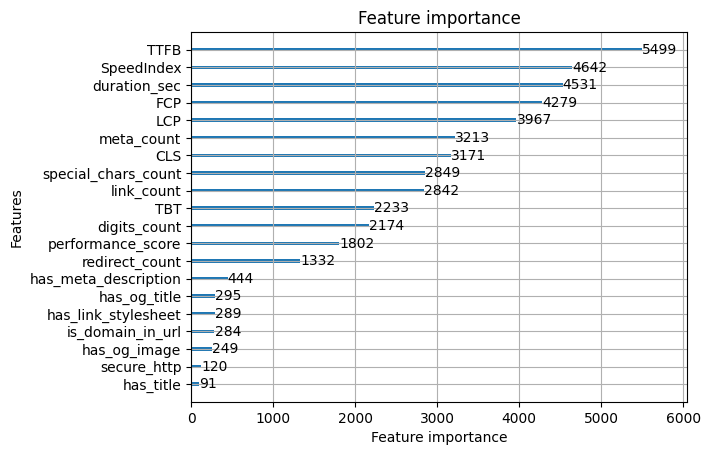

In [20]:
lgb.plot_importance(model, max_num_features=20)